# Lecture 04: Machine Arithmetic

## Fixed point numbers

A basic way of representing numbers is through fixed point arithmetic.
We store a pattern of digits together with a sign and a decimal point:

$$
n_{fi} = \pm a_1 a_2 a_3 a_5 . a_6 a_7 a_8,
$$

where $a_i$ are the decimal/binary numbers used to represent the decimal/binary digits
of $n_{fi}$.

In Julia, we have to import an extra package to use fixed point numbers
(which shows that they are quite rare in practice).
Very common in practice are fixed-point decimals without any decimals, the integers!

In [1]:
using FixedPointDecimals

using PyPlot
PyPlot.svg(true)

true

In [2]:
# create a fixed point decimal with 2 decimal positions
# and as many digits as a 16-bit integer.
# allowed numbers lie between -32768/10^2 < x < 32767/10^2
number1 = FixedDecimal{Int16, 2}(110.34564)

# we see that all decimals beyond the second are rounded

FixedDecimal{Int16,2}(110.35)

In [3]:
number2 = FixedDecimal{Int16, 2}(327.65)

FixedDecimal{Int16,2}(327.65)

In [4]:
# we are beyond the capabilities of this number system, so we get an error message
number3 = FixedDecimal{Int16, 2}(327.68)

InexactError: InexactError: trunc(Int16, 32768.0)

In [5]:
# Let's try adding

# we expect: 110.35 + 327.65 = 438.00
number1 + number2

FixedDecimal{Int16,2}(-217.36)

In [6]:
# Let's try dividing

# true solution 110.35/327.65 = 0.336761474609375
number1 / number2

FixedDecimal{Int16,2}(0.34)

In [7]:
# Sometimes, things work:

FixedDecimal{Int16, 2}(4.55) + FixedDecimal{Int16, 2}(5.45)

FixedDecimal{Int16,2}(10.00)

In [12]:
number1 / FixedDecimal{Int16, 2}(400)

# 110.35 / 400

InexactError: InexactError: trunc(Int16, 40000)

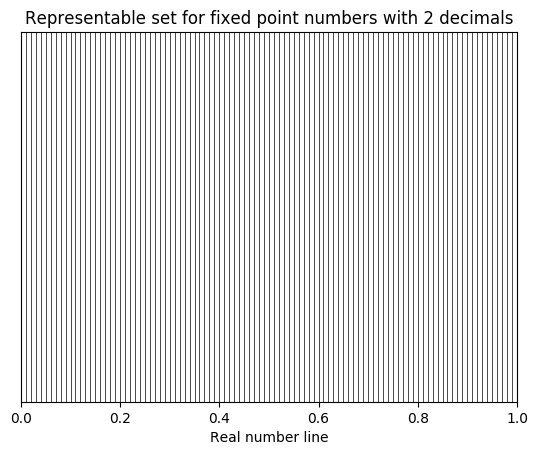

PyObject Text(0.5, 1.0, 'Representable set for fixed point numbers with 2 decimals')

In [13]:
# Visualizing the representable set
function fi_representable_numbers_between(a, b, decimals)
    """ Return all fixed point numbers between a and b
    that have a given number of decimals
    """
    
    a_fp = FixedDecimal{Int16, decimals}(a)
    b_fp = FixedDecimal{Int16, decimals}(b)
    
    dx = 10.0^-decimals
    return collect(a_fp:dx:b_fp)
end

f, ax = subplots()

for number in fi_representable_numbers_between(0.0, 1.0, 2)
    ax[:axvline](number, color="k", linewidth=0.5)
end

ax[:set_yticks]([])
ax[:set_xlabel]("Real number line")
ax[:set_title]("Representable set for fixed point numbers with 2 decimals")

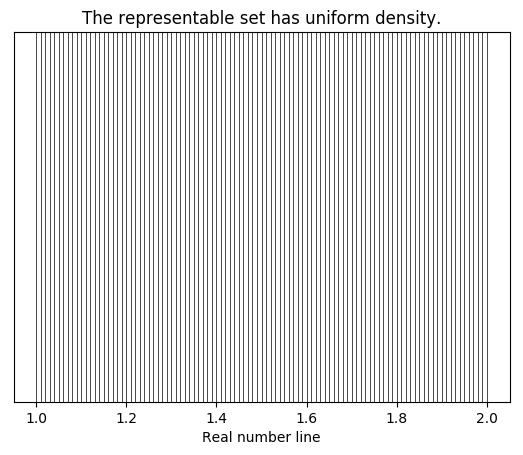

PyObject Text(0.5, 1.0, 'The representable set has uniform density.')

In [14]:
f, ax = subplots()

for number in fi_representable_numbers_between(1.0, 2.0, 2)
    ax[:axvline](number, color="k", linewidth=0.5)
end

ax[:set_yticks]([])
ax[:set_xlabel]("Real number line")
ax[:set_title]("The representable set has uniform density.")

## Floating point numbers

Floating point numbers represent numbers in scientific notation:

$$
n_{fl} = \pm a_1 a_2 a_3 a_4 a_5 \times 10^{\pm a_6 a_7}.
$$

The numbers in front of the exponent are called the *mantissa*.

This leads to an immense increase in range of representable numbers at
the expense of the representable set being non-uniform.

Julia (and basically *all* other programming languages) support 
floating point numbers out of the box. In fact, they are usually implemented in hardware,
according to the IEEE 754 standard. You can read all about this particular implementation here:
https://en.wikipedia.org/wiki/IEEE_754.

### Unexpected behavior: Catastrophic loss of precision

__*Never, ever* compute a small number as a difference of two big numbers!__

As mentioned in the lecture, the big number takes up most of the mantissa,
such that a lot of precision is lost!
The classic example comes from the approximation of derivatives

$$
f'(x) \approx f'(x,h) = \frac{f(x+h) - f(x)}{h}.
$$

In [15]:
# A very simple function.
f0(x) = x

# We are interested in f'(1) = 1

# Set a stepsize. We choose a Float16, which has a smaller mantissa than the default Float64,
# for demonstration purposes.

# Float16 uses 1 bit for the sign, 5 bits for the exponent, and 10 bits for the mantissa
# It uses a binary format, with powers of 2 instead of 10.

# fairly large stepsize
h = Float16(0.5)
x0 = Float16(1.0)

(f0(x0 + h) - f0(x0))/h

Float16(1.0)

In [16]:
# now let's pick a smaller stepsize
h = Float16(0.1)
(f0(x0 + h) - f0(x0))/h

Float16(0.996)

In [17]:
# and now let's pick an even smaller stepsize
h = Float16(0.01)
(f0(x0 + h) - f0(x0))/h

Float16(0.9766)

## The approximations become progressively *worse* because of catastrophic loss of precision!

## Tricks to avoid catastrophic loss of precision
We want to compute
$$
g(x, \Delta) = \sqrt{x+\Delta} - \sqrt{x},
$$
for small $\Delta$ and large $x$. Because of catastrophic loss of precision due to
computing a small number as the difference between two large numbers, we expect this
to be quite imprecise.

In [18]:
g(x, Δ) = √(x + Δ)- √x

x0 = Float16(900)
Δ = Float16(4e-3)

g(x0, Δ)

Float16(0.0)

In [19]:
x0 = Float32(900)
Δ = Float32(4e-3)

g(x0, Δ)

6.67572f-5

In [20]:
x0 = Float64(900)
Δ = Float64(4e-3)

g(x0, Δ)

6.666659259479957e-5

We rewrite the expression to get rid of the difference by
using 
$$
(a+b)(a-b) = a^2 - b^2.
$$

We find
$$
\left(\sqrt{x+\Delta} + \sqrt{x}\right)\left(\sqrt{x+\Delta} - \sqrt{x}\right) = \Delta,
$$
and therefore
$$
\left(\sqrt{x+\Delta} - \sqrt{x}\right) = \frac{\Delta}{\sqrt{x+\Delta} + \sqrt{x}}.
$$

In [21]:
g_improved(x, Δ) = Δ/(√(x + Δ) + √x)

x0 = Float16(900)
Δ = Float16(4e-3)

g_improved(x0, Δ)

Float16(6.67e-5)

In [22]:
x0 = Float32(900)
Δ = Float32(4e-3)

g_improved(x0, Δ)

6.6666595f-5

In [23]:
x0 = Float64(900)
Δ = Float64(4e-3)

g_improved(x0, Δ)

6.66665925927572e-5

__Even for Float16, we get a decent approximation of the true result instead of just zero!__

### Unexpected behavior: Equal numbers are not equal?
Due to roundoff error in floating point calculations,
numbers we *think* are equal really aren't.

In [ ]:
# Clearly, 4.2 - 0.1 = 4.1

(4.2 - 0.1) == 4.1

In [ ]:
# ???? why is this happening?
println(4.1)
println(4.2)
println(0.1)
# println(4.2 - 0.1)

All numbers involved are exactly representable in finite decimals
However, 
$$4.1 = 4.0 + 0.1$$
in binary, 

$$0.1_d = 0.0\overline{0011}_b,$$

with the overlined part infinitely repeating. So internally, the computer must round it to
the next representable floating point number, incurring roundoff error.
When rounding $4.1$, a *different* roundoff error is incurred because the number
has a different scale (remember that roundoff error is relative for floating point arithmetic).

This leads to the rule:

__*Never, ever* check floating point numbers for equality!__

But then what should we do?

In [ ]:
# A naive approach is to replace 
(4.2 - 0.1) == 4.1

# by

ϵ = 0.00001
abs((4.2 - 0.1) - 4.1) < ϵ

# where ϵ is some small number.

In [ ]:
# This seems to work, and indeed Julia provides a good small number for you!
eps()

In [ ]:
# this is the smallest Float16 number such that 1 + eps() is different from 1

println(1.0 + eps() != 1.0)

println(1.0 + eps()/2 != 1.0)

In [ ]:
# However, as mentioned in the lecture, roundoff error for floating point
# numbers is *relative error*, so in reality, we should check

a = 4.2 - 0.1
b = 4.1

abs((a - b)/b) < eps()

In [ ]:
# but this has lots of problems again: What if b = 0? Why is this not symmetric in a and b?

# You can check out what a *correct* implementation should look like here:
# https://floating-point-gui.de/errors/comparison/
# (It's not so simple!)

In [ ]:
# Julia has a helpful function
isapprox(a, b)

In [ ]:
# or (which does the same thing)
# type \approx and then hit the [Tab] key to get the ≈ symbol.
a ≈ b

Here is how it works internally (it's one way to do it, and by no means the only or best way!):

    isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
    
Inexact equality comparison: 

    true if norm(x-y) <= max(atol, rtol*max(norm(x), norm(y))). 

The default atol is zero and the default rtol depends on the types of x and y. The keyword argument nans determines whether or not NaN values are considered equal (defaults to false).

The binary operator ≈ is equivalent to isapprox with the default arguments, and x ≉ y is equivalent to !isapprox(x,y).

Note that x ≈ 0 (i.e., comparing to zero with the default tolerances) is equivalent to x == 0 since the default atol is 0. In such cases, you should either supply an appropriate atol (or use norm(x) ≤ atol) or rearrange your code (e.g. use x ≈ y rather than x - y ≈ 0). It is not possible to pick a nonzero atol automatically because it depends on the overall scaling (the "units") of your problem: for example, in x - y ≈ 0, atol=1e-9 is an absurdly small tolerance if x is the radius of the Earth in meters, but an absurdly large tolerance if x is the radius of a Hydrogen atom in meters.

__In general, how one should compare floating point numbers *depends on the specific case*!
You need to think carefully each time.__

## Accumulation of round-off error

Often we need to sum up many summands of similar size (remember PSET 1?).
If each of the summands has round-off error, these errors can accumulate!

In [ ]:
# A function to evaluate a sum
function sum_direct(x, N)
    """ Sum up ∑_{i=1}^{N} x
    """
    
    S = 0.0;
    for i=1:N
        S += x
    end
    
    return S
end

N = 10

# There is a roundoff-error when computing π/N
(sum_direct(π/N, N) - π)/π

In [ ]:
Ns = 10.0.^collect(2:10)

# compute relative errors
sum_errors = [abs(sum_direct(π/N, N) - π)/π for N in Ns]

loglog(Ns, sum_errors, "o-")
xlabel(L"N")
ylabel("relative error")

## Pairwise summation

Apparently, the error increases with the number of summands.
The reason is: in each consecutive step we add a very small number to
a progressively larger number.
Since a lot of the floating point precision is used to store the large number,
adding a small number incurs a progressively increasing round-off error.

This can be fixed by the technique of pairwise summation:
We compute the sum recursively, by splitting it into two halves, and computing these
individually. This way we always add up numbers of similar magnitude, and thus
incur less roundoff error.

Julia's (and NumPy's) sum function uses this technique!

In [ ]:
# Let's check Julia's sum function:
N = 10
summands = [π/N for i=1:N]

(sum(summands) - π)/π

In [ ]:
# A function to evaluate a sum
function sum_pairwise(x, N; base_threshold=100)
    """ Sum up ∑_{i=1}^{N} x using pairwise summation
    """
    
    # for a small number of summands, we just perform a direct sum
    # this is done to amortize the overhead due to recursion where recursion is not necessary
    if N < base_threshold
        return sum_direct(x, N)
    else
        # split up the summation into two parts of similar magnitude.
        # make sure to correctly handle the case where N is odd.
        N_half = Int64(floor(N/2))
        return sum_pairwise(x, N_half) + sum_pairwise(x, N - N_half)
    end
end

N = 10
(sum_pairwise(π/N, N) - π)/π

In [ ]:
# compute relative errors for the pairwise method
sum_errors_pairwise = [abs(sum_pairwise(π/N, N) - π)/π for N in Ns]

loglog(Ns, sum_errors, "o-", label="direct sum")
loglog(Ns, sum_errors_pairwise, "o-", label="pairwise sum")

legend()
xlabel(L"N")
ylabel("relative error")

You can read more on the theory of pairwise summation here: https://en.wikipedia.org/wiki/Pairwise_summation.
There are other algorithms for reducing round-off errors, but they all come at the cost of computational overhead. One example is https://en.wikipedia.org/wiki/Kahan_summation_algorithm.

## Inf and NaN
The floating point numbers in Julia define special symbols to deal with ill-defined operations:

In [ ]:
# This is a huge number, bigger than any one representable in Float64
exp(1000)

In [ ]:
# This is not an allowed operation
0/0

In [ ]:
# Interesting properties
Inf + Inf

In [ ]:
Inf - Inf

In [ ]:
Inf > NaN

In [ ]:
Inf > -Inf

In [ ]:
Inf < -Inf

In [ ]:
Inf > 100000000000

In [ ]:
Inf*Inf

In [ ]:
-Inf*Inf

In [ ]:
-NaN

In [ ]:
Inf == Inf

In [ ]:
NaN == NaN

In [ ]:
# you can check if your code contains these special values
A = [1, NaN, +Inf, -Inf]

In [ ]:
isfinite.(A)

In [ ]:
isinf.(A)

In [ ]:
isnan.(A)

In [ ]:
# or check individually
isnan(Inf)

In [ ]:
isfinite(2.0)